# Импорт библиотек


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import zipfile
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import joblib
from tqdm import tqdm

# Загрузка основного датасета


In [4]:
df = pd.read_csv('df_clear_uniq_3.csv')
df.shape

(12346, 6)

In [5]:
df.head(5)

,part_num,manufacturer,TNVED,concat_str,path_ds,id_path
0,XC7K410T-2FFG900I,XILINX,8542399010,XC7K410T-2FFG900I XILINX,M:\DataSheet\d76e3861-23b6-11ed-96e5-f8bc12505...,d76e3861-23b6-11ed-96e5-f8bc12505841
1,NC7WZ04P6X,ON SEMICONDUCTOR,8542399010,NC7WZ04P6X ON SEMICONDUCTOR,M:\DataSheet\b09bd526-4a32-11ed-96e6-f8bc12505...,b09bd526-4a32-11ed-96e6-f8bc12505841
2,ADUM1401ARWZ,ANALOG DEVICES,8542399010,ADUM1401ARWZ ANALOG DEVICES,M:\DataSheet\2ff0bfb5-6804-11ee-96f4-f8bc12505...,2ff0bfb5-6804-11ee-96f4-f8bc12505841
3,GCM155R71C104KA55D,MURATA ELECTRONICS,8532240000,GCM155R71C104KA55D MURATA ELECTRONICS,M:\DataSheet\8436bcbb-4a18-11ed-96e6-f8bc12505...,8436bcbb-4a18-11ed-96e6-f8bc12505841
4,ADA4898-1YRDZ,ANALOG DEVICES,8542339000,ADA4898-1YRDZ ANALOG DEVICES,M:\DataSheet\cb8a2892-ddc2-11ed-96f0-f8bc12505...,cb8a2892-ddc2-11ed-96f0-f8bc12505841



# Функция для загрузки суммаризированных данных


In [6]:
def load_summarized_data(zip_path):
    summaries = []
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_name in tqdm(zip_ref.namelist()):
            try:
                with zip_ref.open(file_name) as file:
                    content = file.read().decode('utf-8').strip()
                    
                    # Попытка прочитать как JSON
                    try:
                        data = json.loads(content)
                        summary = data.get('summary', '')
                    except json.JSONDecodeError:
                        # Если не JSON, сохраняем как есть
                        summary = content
                    
                    summaries.append({
                        'id_path': file_name.split('/')[-1].split('.')[0],
                        'summary': summary
                    })
            except Exception as e:
                print(f"Ошибка при обработке файла {file_name}: {str(e)}")
                continue
    return pd.DataFrame(summaries)

# Загрузка и объединение данных
print("Загрузка суммаризированных данных...")
summaries_df = load_summarized_data('datasheets_miro_gpt4o_mini_7k.zip')
df = df.merge(summaries_df, on='id_path', how='left')

Загрузка суммаризированных данных...


100%|██████████| 10153/10153 [00:02<00:00, 4785.87it/s]


# Анализ данных

In [7]:
print("\nАнализ данных:")
print(f"Всего записей: {len(df)}")
print(f"Уникальных TNVED кодов: {df['TNVED'].nunique()}")
print("\nТоп-10 TNVED кодов:")
print(df['TNVED'].value_counts().head(10))


Анализ данных:
Всего записей: 12346
Уникальных TNVED кодов: 87

Топ-10 TNVED кодов:
TNVED
8542399010    2676
8536693000    1107
8533100000     926
8532240000     742
8541100009     662
8542339000     460
8504509500     377
8541290000     357
8542319010     301
other          286
Name: count, dtype: int64


# Визуализация распределения классов

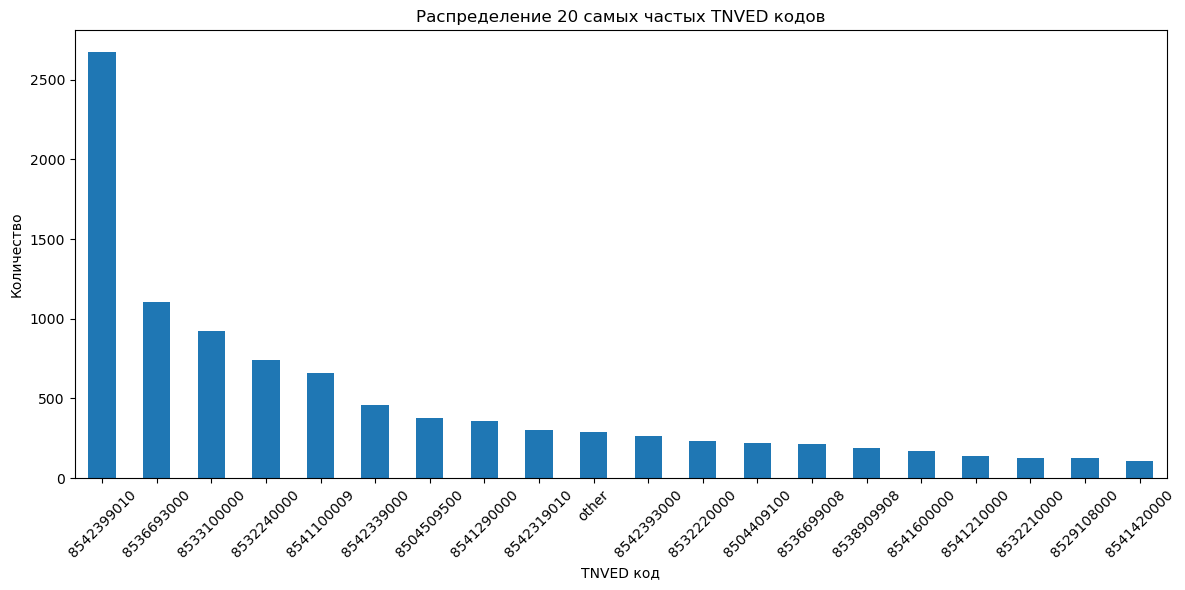

In [8]:
plt.figure(figsize=(12, 6))
df['TNVED'].value_counts().head(20).plot(kind='bar')
plt.title('Распределение 20 самых частых TNVED кодов')
plt.xlabel('TNVED код')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Простая предобработка текста

In [10]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ''
    # Удаление специальных символов
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['processed_part_num'] = df['part_num'].apply(preprocess_text)
df['processed_manufacturer'] = df['manufacturer'].apply(preprocess_text)
df['processed_summary'] = df['summary'].apply(preprocess_text)

# Создание объединенного текстового признака

In [11]:
df['combined_text'] = (
    df['processed_part_num'] + ' ' + 
    df['processed_manufacturer'] + ' ' + 
    df['processed_summary']
)

# Кодирование TNVED кодов
label_encoder = LabelEncoder()
df['TNVED_encoded'] = label_encoder.fit_transform(df['TNVED'])

# Разделение данных

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df['combined_text'],
    df['TNVED_encoded'],
    test_size=0.2,
    random_state=42,
    stratify=df['TNVED_encoded']
)

# Векторизация текста с помощью TF-IDF
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    stop_words='english'
)
print("\nВекторизация текста...")


Векторизация текста...


# Обучение модели RandomForest

In [14]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


print("Обучение модели...")
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf.fit(X_train_tfidf, y_train)

# Оценка модели
y_pred = rf.predict(X_test_tfidf)
print("\nОценка модели:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Обучение модели...

Оценка модели:
Accuracy: 0.7963562753036437

Classification Report:
              precision    recall  f1-score   support

  3818001000       0.67      1.00      0.80         2
  3818009000       0.67      0.67      0.67         6
  3926909709       1.00      0.42      0.59        12
  7318155900       0.00      0.00      0.00         1
  7326909807       0.00      0.00      0.00         1
  7419800000       1.00      0.91      0.95        11
  7616999008       0.71      0.38      0.50        13
  8414592000       1.00      1.00      1.00         7
  8471500000       0.80      0.57      0.67         7
  8471900000       0.29      0.22      0.25         9
  8473302008       0.50      0.29      0.36         7
  8486400009       0.00      0.00      0.00         0
  8504312909       1.00      1.00      1.00         3
  8504318007       1.00      0.65      0.79        20
  8504408300       1.00      0.75      0.86         4
  8504409100       0.90      0.80      0.84    

c:\Users\Aleksandr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aleksandr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aleksandr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aleksandr\anaconda3\Lib\sit

# Создание pipeline

In [15]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1, 2),
        stop_words='english'
    )),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

print("\nОбучение pipeline на всех данных...")
pipeline.fit(df['combined_text'], df['TNVED_encoded'])


Обучение pipeline на всех данных...


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

# Функция для предсказания TNVED кода

In [16]:
def predict_tnved(part_num, manufacturer, description=None):
    """
    Функция для предсказания TNVED кода
    
    Параметры:
    part_num - партномер компонента
    manufacturer - производитель
    description - текстовое описание (опционально)
    
    Возвращает:
    TNVED код
    """
    processed_part = preprocess_text(part_num)
    processed_manuf = preprocess_text(manufacturer)
    processed_desc = preprocess_text(description) if description else ""
    
    combined = f"{processed_part} {processed_manuf} {processed_desc}"
    
    encoded = pipeline.predict([combined])
    return label_encoder.inverse_transform(encoded)[0]

# Пример использования

In [17]:
sample_part_num = "STM32F103C8T6"
sample_manufacturer = "STMicroelectronics"
sample_desc = "32-bit ARM Cortex-M3 microcontroller with 64 Kbytes Flash"

predicted_tnved = predict_tnved(sample_part_num, sample_manufacturer, sample_desc)
print(f"\nПример предсказания для {sample_part_num}: {predicted_tnved}")


Пример предсказания для STM32F103C8T6: 8471500000


# Сохранение модели

In [18]:
print("\nСохранение модели...")
os.makedirs('model', exist_ok=True)
joblib.dump(pipeline, 'model/pipeline.joblib')
joblib.dump(label_encoder, 'model/label_encoder.joblib')
joblib.dump(tfidf, 'model/tfidf.joblib')


Сохранение модели...


['model/tfidf.joblib']

# Создание архива с моделью

In [19]:
import shutil
shutil.make_archive('tnved_classifier', 'zip', 'model')
print("\nМодель сохранена в файле tnved_classifier.zip")


Модель сохранена в файле tnved_classifier.zip
